In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 0us/step


In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.sample(frac=1).head()

,target,source
452,1365,562123
484,1481,399173
3459,63931,6939
2674,28957,94713
2669,28957,189577


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
# print(papers.subject.value_counts())

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

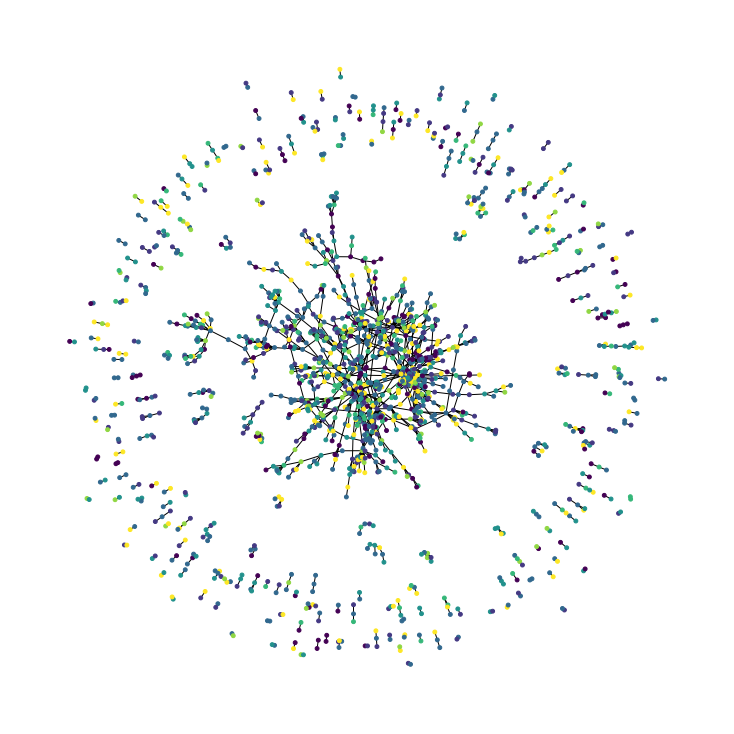

In [ ]:
plt.figure(figsize=(10, 10))
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2162, 1435)
Test data shape: (546, 1435)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
8/8 [==============================] - 6s 141ms/step - loss: 3.1924 - acc: 0.1943 - val_loss: 1.8778 - val_acc: 0.3046
Epoch 2/300
8/8 [==============================] - 0s 36ms/step - loss: 2.3591 - acc: 0.2390 - val_loss: 1.8772 - val_acc: 0.3077
Epoch 3/300
8/8 [==============================] - 0s 36ms/step - loss: 2.0424 - acc: 0.2608 - val_loss: 1.8490 - val_acc: 0.3077
Epoch 4/300
8/8 [==============================] - 0s 30ms/step - loss: 1.9223 - acc: 0.2934 - val_loss: 1.8186 - val_acc: 0.3077
Epoch 5/300
8/8 [==============================] - 0s 29ms/step - loss: 1.8195 - acc: 0.3223 - val_loss: 1.7840 - val_acc: 0.3231
Epoch 6/300
8/8 [==============================] - 0s 27ms/step - loss: 1.7824 - acc: 0.3489 - val_loss: 1.7488 - val_acc: 0.3662
Epoch 7/300
8/8 [==============================] - 0s 29ms/step - loss: 1.6586 - acc: 0.3734 - val_loss: 1.7042 - val_acc: 0.3815
Epoch 8/300
8/8 [==============================] - 0s 29ms/step - loss: 1.5544 - acc: 0.4

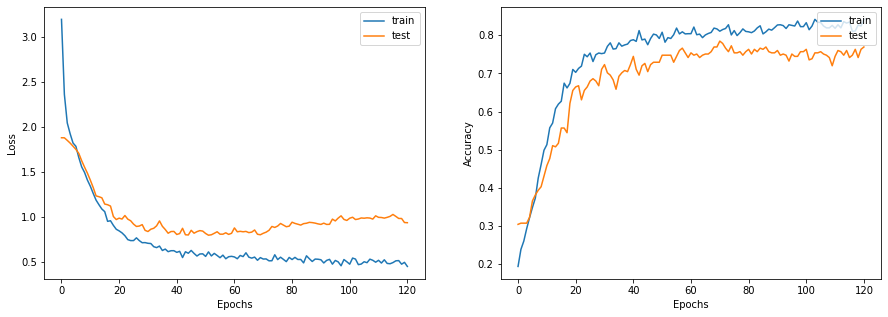

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 77.84%


In [ ]:
# make predictions
pred = baseline_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)

18/18 [==============================] - 0s 6ms/step


In [ ]:
print("Confusion matrix: ")
print(confusion_matrix(y_test , y_pred))
print(" ")
print("F1 score: ", f1_score(y_test , y_pred, average = 'macro'))

Confusion matrix: 
[[ 48   3   4   1   2   4   4]
 [  0  76   6   2   1   0   2]
 [  1   2 127  15   3   3   6]
 [  0   1   9  57   0   0   2]
 [  2   4   6   4  26   0   2]
 [  3   2   1   1   0  29   1]
 [  3   2  12   2   0   5  62]]
 
F1 score:  0.766049578805606
